In [34]:
import warnings
from timy.settings import timy_config

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
timy_config.tracking = False

In [35]:
from dtextract.data.data import ID, NUM, CAT_RES

output = 'logs/newsgroups_3000_features.txt'  # The log file in which the log of running code will be written
path = '../data/20_newsgroups_3000_features.csv'  # Path to the input dataset in csv format
data_types = [ID] * 1 + [NUM] * 3000 + [CAT_RES]
has_header = True
isClassify = True 
classNames = {0: 'Christian', 1: 'Atheism'}


In [36]:
# decision tree extraction parameters
nComponents = 500  # Number of components (the gaussian mixtures)
maxSize = 64  # maximum tree size
nPts = 2000  # Number of points used in active sampling
nTestPts = 500  # Number of test points used in Active sampling
maxDtSize = maxSize  # decision tree training parameters
tgtScore = None
minGain = 1e-4

# random forest parameters
nTrees = 100 

# training data proportion
trainingProp = 0.7


In [37]:
from dtextract.util.log import *
from dtextract.data.data import readCsv

setCurOutput(output)
log('Parsing CSV...', INFO)
(df, res, resMap, catFeats, columnNames) = readCsv(path, has_header, data_types)
log('Done!', INFO)


Parsing CSV...
Reading file: ../data/20_newsgroups_3000_features.csv
Done!
Rows read: 1796
Columns: 3001
Column names:
0: 00
1: 000
2: 01
3: 02
4: 03
5: 0358
6: 04
7: 05
8: 0539
9: 07
10: 08
11: 09
12: 10
13: 100
14: 103
15: 107
16: 11
17: 11292
18: 12
19: 127
20: 13
21: 14
22: 141520
23: 14801
24: 15
25: 15118
26: 155002jsn104
27: 16
28: 17
29: 18
30: 19
31: 1971
32: 1990
33: 1993
34: 1993apr10
35: 1993apr12
36: 1993apr13
37: 1993apr14
38: 1993apr15
39: 1993apr16
40: 1993apr17
41: 1993apr19
42: 1993apr2
43: 1993apr20
44: 1993apr21
45: 1993apr3
46: 1993apr5
47: 20
48: 200
49: 2000
50: 21
51: 22
52: 23
53: 232
54: 24
55: 241
56: 245
57: 25
58: 26
59: 27
60: 28
61: 28388
62: 29
63: 30
64: 30602
65: 31
66: 32
67: 33
68: 34
69: 35
70: 3553
71: 36
72: 37
73: 38
74: 39
75: 3rd
76: 40
77: 408
78: 41
79: 42
80: 428
81: 44
82: 45
83: 46
84: 47
85: 48
86: 4949
87: 50
88: 51
89: 52
90: 53
91: 54
92: 542
93: 55
94: 56
95: 57
96: 58
97: 59
98: 5l3
99: 60
100: 6086
101: 612
102: 66
103: 696
104: 741

In [38]:
from dtextract.data.data import split
log('Splitting into training and test...', INFO)
(trainDf, testDf) = split(df, trainingProp)
log('Done!', INFO)


Splitting into training and test...
Done!


In [39]:
from dtextract.data.data import constructDataMatrix
log('Constructing data matrices...', INFO)
(XTrain, yTrain, catFeatIndsTrain, numericFeatIndsTrain) = constructDataMatrix(trainDf, res, catFeats)
(XTest, yTest, catFeatIndsTest, numericFeatIndsTest) = constructDataMatrix(testDf, res, catFeats)
log('Done!', INFO)



Constructing data matrices...
Done!


In [40]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

log('Training random forest...', INFO)
rfConstructor = RandomForestClassifier if isClassify else RandomForestRegressor
rf = rfConstructor(n_estimators=nTrees)
rf.fit(XTrain, yTrain)
log('Done!', INFO)



Training random forest...
Done!


In [41]:
from dtextract.util.util import f1Vec, mseVec

rfScoreFunc = f1Vec if isClassify else mseVec
rfTrainScore = rfScoreFunc(rf.predict, XTrain, yTrain)
rfTestScore = rfScoreFunc(rf.predict, XTest, yTest)
log('Training score: ' + str(rfTrainScore), INFO)
log('Test score: ' + str(rfTestScore), INFO)


Training score: 1.0
Test score: 0.9674620390455533


In [42]:
from dtextract.core.learn import ParamsLearn
from dtextract.impl.simp import ParamsSimp
from dtextract.impl.funcs import getRfFunc

# Step 2: Set up decision tree extraction inputs
paramsLearn = ParamsLearn(tgtScore, minGain, maxSize)
paramsSimp = ParamsSimp(nPts, nTestPts, isClassify)

# Step 3: Function
rfFunc = getRfFunc(rf)


In [43]:
from dtextract.impl.dists import CategoricalGaussianMixtureDist as CGMD
dist = CGMD(XTrain, catFeatIndsTrain, numericFeatIndsTrain, nComponents)


Fitting Gaussian mixture with 500 components...
Done!


In [44]:
from dtextract.impl.simp import learnDTSimp, genAxisAligned

# Step 5: Extract decision tree
dtExtract, dtMap = learnDTSimp(genAxisAligned, rfFunc, dist, paramsLearn, paramsSimp)


Sampling 2000 points
Done! Sampled 2000 points
Generating internal node with number of samples 2000...
Done!
Generating leaf with number of samples 2000...
Done!
Current mass: 1.0000000000000009
Sampling 2000 test points
Done! Sampled 2000 test points
Computed internal score: 0.7940000000000007
Computed leaf score: 0.5120000000000005
Putting gain: 0.28200000000000025
Internal node index: 0
Sampling 2000 points
Done! Sampled 2000 points
Generating internal node with number of samples 2000...
Done!
Generating leaf with number of samples 2000...
Done!
Current mass: 0.639218678902483
Sampling 2000 test points
Done! Sampled 2000 test points
Computed internal score: 0.5037043189751566
Computed leaf score: 0.448731512589543
Sampling 2000 points
Done! Sampled 2000 points
Generating internal node with number of samples 2000...
Done!
Generating leaf with number of samples 2000...
Done!
Current mass: 0.3607813210975179
Sampling 2000 test points
Done! Sampled 2000 test points
Computed internal sco

Done! Sampled 2000 points
Generating internal node with number of samples 2000...
Done!
Generating leaf with number of samples 2000...
Done!
Current mass: 0.021540839391515774
Sampling 2000 test points
Done! Sampled 2000 test points
Computed internal score: 0.012795258598560368
Computed leaf score: 0.012795258598560368
Sampling 2000 points
Done! Sampled 2000 points
Generating internal node with number of samples 2000...
Done!
Generating leaf with number of samples 2000...
Done!
Current mass: 0.012383557418794195
Sampling 2000 test points
Done! Sampled 2000 test points
Computed internal score: 0.00817314789640417
Computed leaf score: 0.00817314789640417
Current gain: 0.0046306801646073086
Current score: 0.893309044706525
Current size: 23
Internal node index: 17
Sampling 2000 points
Done! Sampled 2000 points
Generating internal node with number of samples 2000...
Done!
Generating leaf with number of samples 2000...
Done!
Current mass: 0.02929510818798889
Sampling 2000 test points
Done! S

Trained proposed decision tree:
Node count: 39


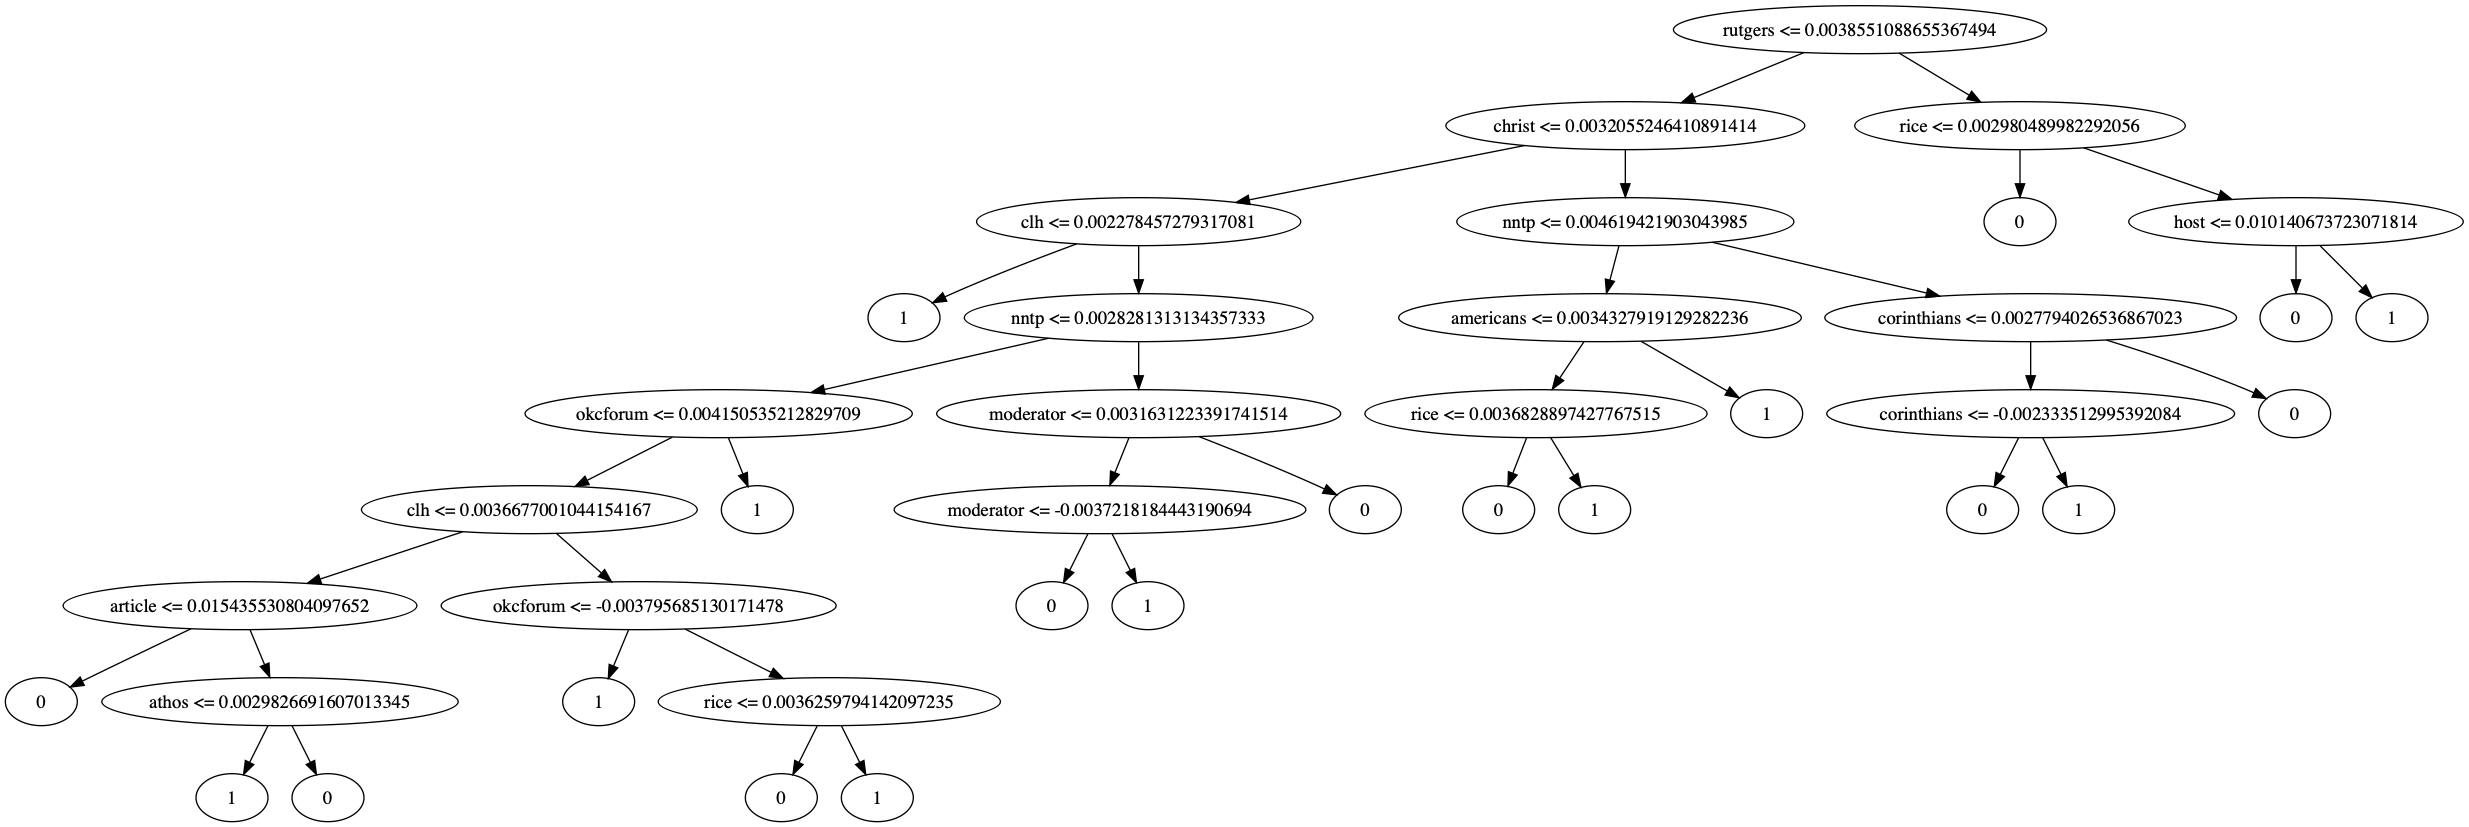

In [45]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
log('Trained proposed decision tree:', INFO)
log('Node count: ' + str(dtExtract.nNodes()), INFO)

graphviz_data = dtExtract.toDotGraph(hasHeader=has_header, columnNames=columnNames)
graph = pydotplus.graph_from_dot_data(graphviz_data)
Image(graph.create_png())


In [46]:
from dtextract.util.util import f1, mse

scoreFunc = f1 if isClassify else mse

dtExtractRelTrainScore = scoreFunc(dtExtract.eval, XTrain, rf.predict(XTrain))
dtExtractRelTestScore = scoreFunc(dtExtract.eval, XTest, rf.predict(XTest))

log('Relative training score: ' + str(dtExtractRelTrainScore), INFO)
log('Relative test score: ' + str(dtExtractRelTestScore), INFO)

dtExtractTrainScore = scoreFunc(dtExtract.eval, XTrain, yTrain)
dtExtractTestScore = scoreFunc(dtExtract.eval, XTest, yTest)

log('Training score: ' + str(dtExtractTrainScore), INFO)
log('Test score: ' + str(dtExtractTestScore), INFO)


Relative training score: 0.8138337012509198
Relative test score: 0.7564766839378237
Training score: 0.8138337012509198
Test score: 0.7837837837837838


In [47]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Step 6: Train a (greedy) decision tree
log('Training greedy decision tree', INFO)
maxLeaves = (maxDtSize + 1)//2
dtConstructor = DecisionTreeClassifier if isClassify else DecisionTreeRegressor
dtTrain = dtConstructor(max_leaf_nodes=maxLeaves)
dtTrain.fit(XTrain, rfFunc(XTrain))
log('Done!', INFO)
log('Node count: ' + str(dtTrain.tree_.node_count), INFO)


Training greedy decision tree
Done!
Node count: 63


In [48]:
dtTrainRelTrainScore = scoreFunc(lambda x: dtTrain.predict(x.reshape(1, -1)), XTrain, rf.predict(XTrain))
dtTrainRelTestScore = scoreFunc(lambda x: dtTrain.predict(x.reshape(1, -1)), XTest, rf.predict(XTest))

log('Relative training score: ' + str(dtTrainRelTrainScore), INFO)
log('Relative test score: ' + str(dtTrainRelTestScore), INFO)


Relative training score: 0.9946808510638298
Relative test score: 0.9257641921397379


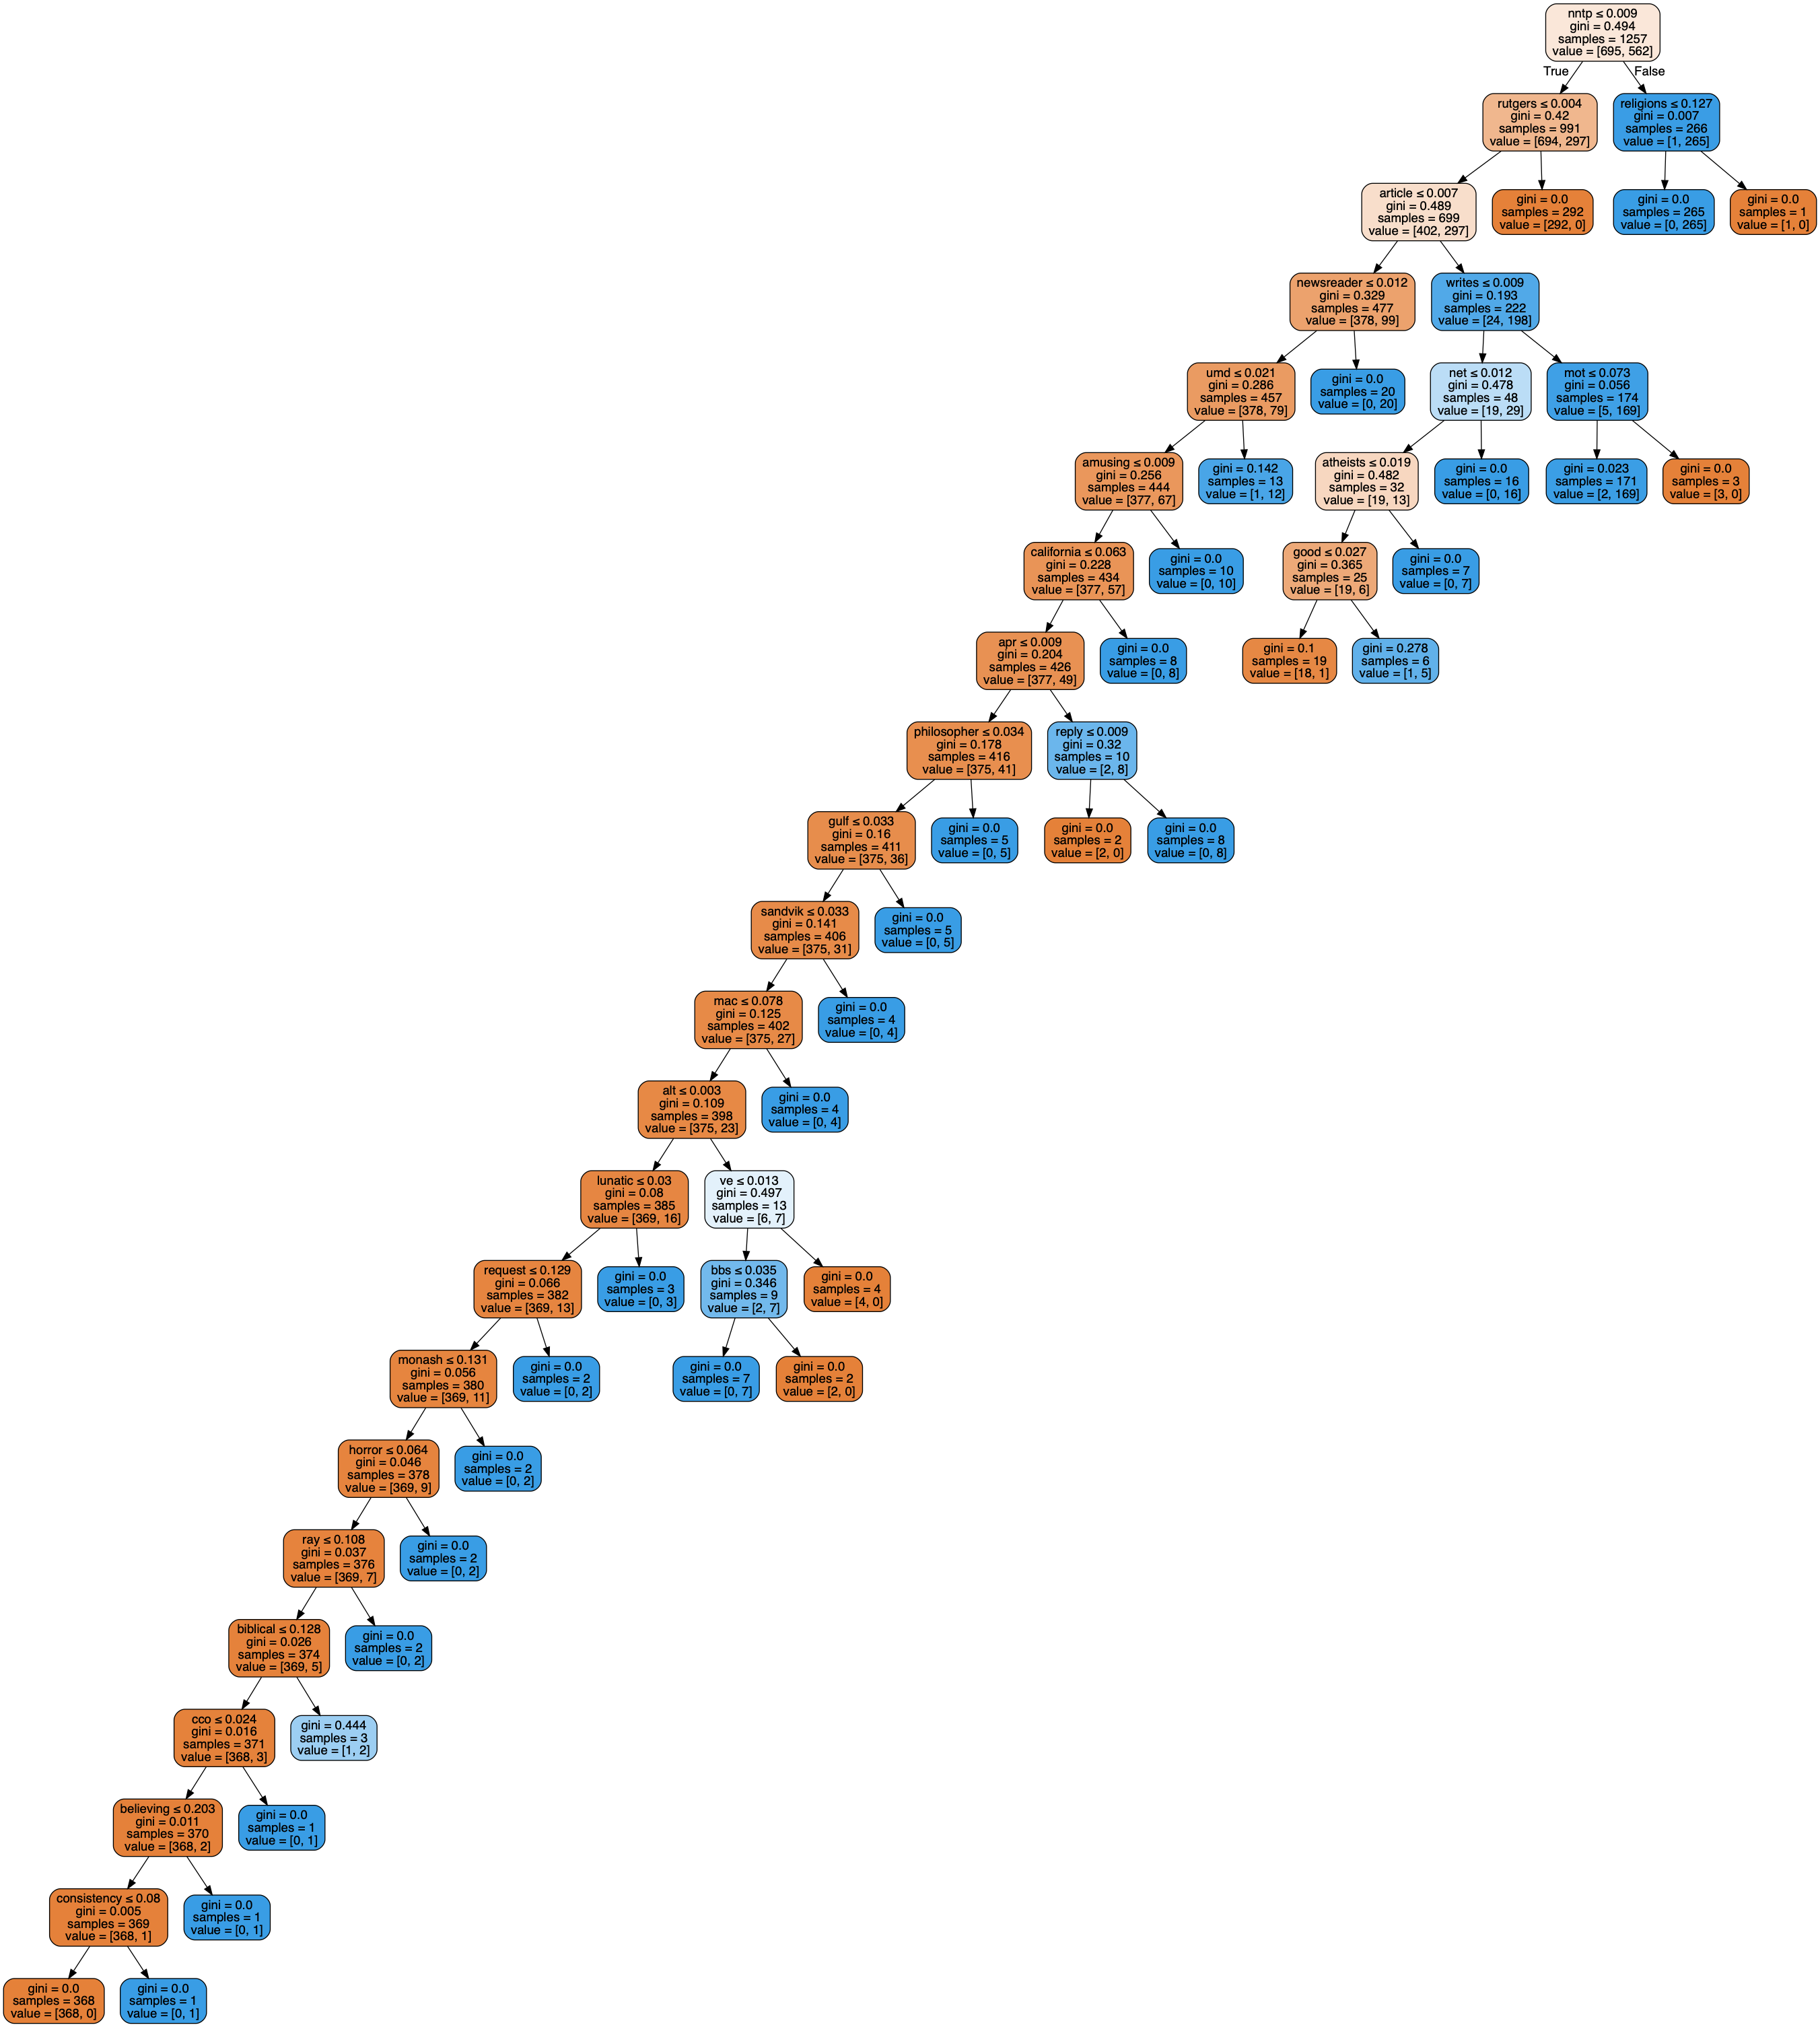

In [49]:
from sklearn.externals.six import StringIO  

dot_data = StringIO()
export_graphviz(dtTrain, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=columnNames[:-1])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [50]:
dtTrainTrainScore = scoreFunc(lambda x: dtTrain.predict(x.reshape(1, -1)), XTrain, yTrain)
dtTrainTestScore = scoreFunc(lambda x: dtTrain.predict(x.reshape(1, -1)), XTest, yTest)
    
log('Training score: ' + str(dtTrainTrainScore), INFO)
log('Test score: ' + str(dtTrainTestScore), INFO)


Training score: 0.9946808510638298
Test score: 0.9384288747346072


In [51]:
from dtextract.interpreter.dt_interpreter import *

predictions, biases, contributions = interpret_tree(dtExtract, dtMap, XTrain, yTrain)
assert_interpretation(predictions, biases, contributions)
    

Classes count is 2
Biases:
[[0.55290374 0.44709626]
 [0.55290374 0.44709626]
 [0.55290374 0.44709626]
 ...
 [0.55290374 0.44709626]
 [0.55290374 0.44709626]
 [0.55290374 0.44709626]]
Line shape is: (3000, 2)
Contibs:
[array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
      

In [52]:
descriptions = ''
if has_header:
    # NOTE: here you should trim the headers array to be the array of names of input columns 
    # with the same size as the number of columns. for example if the first row is and id row 
    # and the last row is the label row, you can use: 
    headers = list(pd.read_csv(path))[1:-1]
    headers = np.array(headers)
    exps = interpret_samples(rf, dtExtract, XTrain, contributions, labels=headers)
    for i in range(len(exps)):
        descriptions += exps[i].get_description(5, True, headers)
else:
    exps = interpret_samples(rf, dtExtract, XTest, contributions)
    for i in range(len(exps)):
        descriptions += exps[i].get_description(5)
        

In [53]:
from importlib import reload
from dtextract.interpreter.visualize import text_visualizer as tv
reload(tv)
tv.init_notebook_visualization()

ind = 532
tv.visualize_normal(columnNames, biases[ind], predictions[ind], exps[ind], classNames)

15 22 accepting adam andy beginning believe bgsu care christians clh creation different doesn edu fall faq gen god green homosexuality human intended ken kind life like live ll lord man mean moderator note obviously oh paul result rom saved sin state statement stop story times took university view views work working writes
##################################################


In [54]:
ind = 54
tv.visualize_normal(columnNames, biases[ind], predictions[ind], exps[ind], classNames)

11 _him_ agnostics amusing apples atheist atheists bake ca canada cause christian claimed connor conquered david don edu extermination fraser khan killed koresh loved mcl millions mix mongols nancy oranges people right rule say simon stalin state timmbake timmons ucsb university unsympathetic worse writes
##################################################
No contribution from existing words!


In [55]:
ind = 345
tv.visualize_normal(columnNames, biases[ind], predictions[ind], exps[ind], classNames)

11 bryan calling christ comment contain copy does edu file going homosexuality hulman issue like love mail mentioned moderator news nextwork note personal post posts read reading reply rose send service specific stop suggestion whitsebd whitsell
##################################################


In [56]:
ind = 3
tv.visualize_normal(columnNames, biases[ind], predictions[ind], exps[ind], classNames)

01 05 10 15 1993 32 50 55 60 absolute accept andy answer apr arrogance article ask asked asking atheist athos basis believe bgsu bible blind blindly body bring california choose christian christians contrary course created decision did difference dog edu evidence exactly exists experience experiences extent eye faith father feel follow follows god hear help important know knows lately led lie lies like listen logic long lord love loves make need newspaper open peace people person personally quite radio read reading real reality really received regardless reject rely remember results revealed right rutgers san saved seeing share simple sound strong suggest term things think time trust truth try ucsd understand university want wish works world writes
##################################################
No contribution from non-existing words!
